In [1]:
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from lsst.sims.featureScheduler.mockTelem import Mock_observatory
from lsst.sims.featureScheduler.schedulers import Core_scheduler
from lsst.sims.featureScheduler.utils import standard_goals, calc_norm_factor, schema_converter
import lsst.sims.featureScheduler.basis_functions as bf
from lsst.sims.featureScheduler.surveys import (generate_dd_surveys, Greedy_survey,
                                                Blob_survey, Pairs_survey_scripted)
from lsst.sims.utils import (_hpid2RaDec, _raDec2Hpid)

In [2]:
# Re-create the scheduler object as it was before

In [3]:
def gen_greedy_surveys(nside):
    """
    Make a quick set of greedy surveys
    """
    target_map = standard_goals(nside=nside)
    norm_factor = calc_norm_factor(target_map)
    # Let's remove the bluer filters since this should only be near twilight
    filters = ['r', 'i', 'z', 'y']
    surveys = []

    for filtername in filters:
        bfs = []
        bfs.append(bf.M5_diff_basis_function(filtername=filtername, nside=nside))
        bfs.append(bf.Target_map_basis_function(filtername=filtername,
                                                target_map=target_map[filtername],
                                                out_of_bounds_val=np.nan, nside=nside,
                                                norm_factor=norm_factor))
        bfs.append(bf.Slewtime_basis_function(filtername=filtername, nside=nside))
        bfs.append(bf.Strict_filter_basis_function(filtername=filtername))
        # Masks, give these 0 weight
        bfs.append(bf.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=60., max_alt=76.))
        bfs.append(bf.Moon_avoidance_basis_function(nside=nside, moon_distance=40.))
        bfs.append(bf.Clouded_out_basis_function())

        bfs.append(bf.Filter_loaded_basis_function(filternames=filtername))

        weights = np.array([3.0, 0.3, 3., 3., 0., 0., 0., 0.])
        surveys.append(Greedy_survey(bfs, weights, block_size=1, filtername=filtername,
                                     dither=True, nside=nside, ignore_obs='DD'))

    return surveys


def generate_blobs(nside):
    target_map = standard_goals(nside=nside)
    norm_factor = calc_norm_factor(target_map)

    # List to hold all the surveys (for easy plotting later)
    surveys = []

    # Set up observations to be taken in blocks
    filter1s = ['u', 'g', 'r', 'i', 'z', 'y']
    filter2s = [None, 'g', 'r', 'i', None, None]
    # Ideal time between taking pairs
    pair_time = 22.
    times_needed = [pair_time, pair_time*2]
    for filtername, filtername2 in zip(filter1s, filter2s):
        bfs = []
        bfs.append(bf.M5_diff_basis_function(filtername=filtername, nside=nside))
        if filtername2 is not None:
            bfs.append(bf.M5_diff_basis_function(filtername=filtername2, nside=nside))
        bfs.append(bf.Target_map_basis_function(filtername=filtername,
                                                target_map=target_map[filtername],
                                                out_of_bounds_val=np.nan, nside=nside,
                                                norm_factor=norm_factor))
        if filtername2 is not None:
            bfs.append(bf.Target_map_basis_function(filtername=filtername2,
                                                    target_map=target_map[filtername2],
                                                    out_of_bounds_val=np.nan, nside=nside,
                                                    norm_factor=norm_factor))
        bfs.append(bf.Slewtime_basis_function(filtername=filtername, nside=nside))
        bfs.append(bf.Strict_filter_basis_function(filtername=filtername))
        # Masks, give these 0 weight
        bfs.append(bf.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=60., max_alt=76.))
        bfs.append(bf.Moon_avoidance_basis_function(nside=nside, moon_distance=30.))
        bfs.append(bf.Clouded_out_basis_function())
        filternames = [fn for fn in [filtername, filtername2] if fn is not None]
        bfs.append(bf.Filter_loaded_basis_function(filternames=filternames))
        if filtername2 is None:
            time_needed = times_needed[0]
        else:
            time_needed = times_needed[1]
        bfs.append(bf.Time_to_twilight_basis_function(time_needed=time_needed))
        bfs.append(bf.Not_twilight_basis_function())
        weights = np.array([3.0, 3.0, .3, .3, 3., 3., 0., 0., 0., 0., 0., 0.])
        if filtername2 is None:
            # Need to scale weights up so filter balancing still works properly.
            weights = np.array([6.0, 0.6, 3., 3., 0., 0., 0., 0., 0., 0.])
        if filtername2 is None:
            survey_name = 'blob, %s' % filtername
        else:
            survey_name = 'blob, %s%s' % (filtername, filtername2)
        surveys.append(Blob_survey(bfs, weights, filtername1=filtername, filtername2=filtername2,
                                   ideal_pair_time=pair_time,
                                   survey_note=survey_name, ignore_obs='DD', dither=True))

    return surveys


In [4]:
nside = 32
survey_length = 365.25*10  # Days
years = int(survey_length/365.25)

greedy = gen_greedy_surveys(nside)
ddfs = generate_dd_surveys(nside=nside)
blobs = generate_blobs(nside)

surveys = [ddfs, blobs, greedy]

n_visit_limit = None
scheduler = Core_scheduler(surveys, nside=nside)
observatory = Mock_observatory(nside=nside)

In [5]:
# Load observations back into an array
sco = schema_converter()
observations = sco.opsim2obs('blob_10.db')

(0, 0.3)

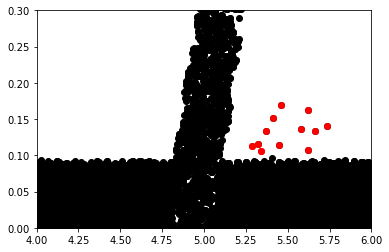

In [6]:
z = np.where(observations['filter'] == 'z')
plt.plot(observations['RA'][z], observations['dec'][z], 'ko')
strange = np.where((observations['dec'] > 0.1) & (observations['RA'] > 5.25) &
                   (observations['RA'] < 6) & (observations['dec'] < 0.2))
plt.plot(observations['RA'][strange], observations['dec'][strange], 'ro')
plt.xlim([4,6])
plt.ylim([0,.3])

In [7]:
strange

(array([ 707003,  707004,  707005,  707006,  731368,  928154,  928155,
         928156,  928157,  928158, 2359475, 2359476, 2359495, 2359496]),)

In [8]:
observations[strange[0][0]]['slewtime']

4.9107666015625

In [9]:
np.degrees(observations[strange[0]]['moonDist'])

array([ 33.5335865 ,  31.88107106,  28.95188436,  30.74721524,
        30.30887103,  37.62574402,  35.6336476 ,  33.73176679,
        31.90857141,  30.88739648,  32.90506019,  29.97336088,
        32.97556715,  30.04195756])

In [10]:
# Play the observations back into the scheduler. This needs to happen in order!
for obs in observations[0:strange[0][0]-4]:
    scheduler.add_observation(obs)

In [11]:
obs

(706998,  5.5628964, -0.15719248,  60926.10865559,  60926.13424187,  30., 'z',  3.26429459, 2,  1.07404401,  0.391388,  0.57225203,  0.63291001,  17.90710118, 1086,  4.81186533,  34.,  0.05095606,  22.85624003,  1.19730882,  0.13294843,  3.25779759,  0.,  0.81448052, -0.90443188, 'blob, z', -1, 0, 1,  21.05234018,  6.27668832,  1.01922481,  4.12254442,  0.,  0.,  6.13100498, -0.05775611,  0.57318903,  0.7342279,  97.02987043)

In [12]:
# Set the observatory to the correct state. Takes a while because it has to load the sky brightness file.
observatory.mjd = obs['mjd']
# Observatory starts parked, so need to send an expose command to slew to the correct position
temp = observatory.observe(obs)
# It took some time to make that slew, so reset the time again
observatory.mjd = obs['mjd']
obs_worked, should_match_obs, new_night = observatory.observe(obs)


/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/mockTelem/mock_observatory.py:443: UserWarning: overriding requested rotSkyPos value
  warnings.warn('overriding requested rotSkyPos value')


In [13]:
obs_worked, new_night

(True, False)

In [14]:
# Check that we are indeed able to repeat the observation we thought
should_match_obs

(1,  5.5628964, -0.15719248,  60926.11049278,  60926.13424187,  30., 'z',  3.23100951, 2,  1.07346337,  0.43105,  0.59476044,  0.66029251,  17.90736337, 1086,  2.73345423,  34.,  0.,  22.81452233,  1.19869154,  0.09497132,  3.22463169,  0.,  0.82263899, -0.91269266, 'blob, z', -1, 0, 1,  21.09655353,  6.27680749,  1.00784204,  4.10963708,  2.90634157,  0.10070319,  6.13127291, -0.05753938,  0.5734944,  2.65742238,  97.02011617)

In [15]:
# update the scheduler conditions
scheduler.update_conditions(observatory.return_conditions())

/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/mockTelem/mock_observatory.py:279: RuntimeWarning: invalid value encountered in less
  slewtimes[np.where(slewtimes < 0)] = np.nan


/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


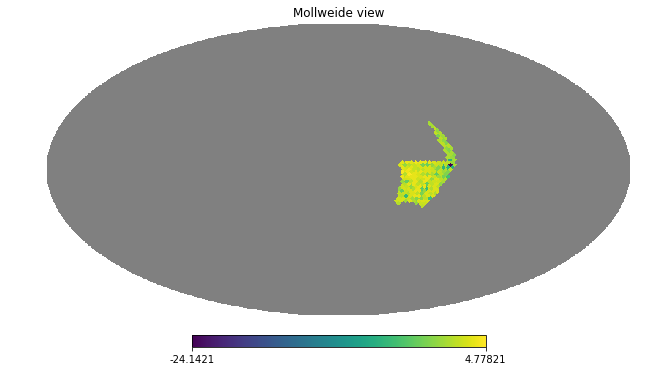

In [16]:
# Now we can look at individual reward functions to see what's going on.
# Here's the blob survey
hp.mollview(scheduler.survey_lists[1][-2].calc_reward_function(scheduler.conditions))

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


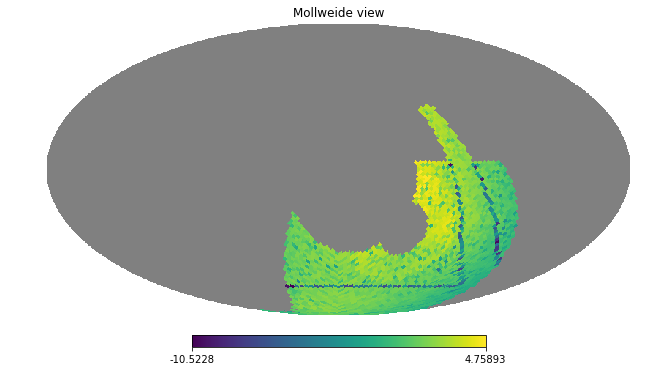

In [17]:
# And the greedy algo. Looks like the moon is cutting out a large chunk.
hp.mollview(scheduler.survey_lists[2][-2].calc_reward_function(scheduler.conditions))